**Подключение библиотек и скриптов**

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

from scipy.stats import probplot

import seaborn as sns

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import catboost as catb
import xgboost as xgb

# Подготовка данных

**Кастомные функции**

In [2]:
get_obj_by_not_null_feature = lambda df, feature_name: df.loc[~df[feature_name].isnull()]

not_null_count = lambda df, feature_name: df.loc[~df[feature_name].isnull()].shape[0]

In [3]:
def distr_qq_plots(df, feature_name, sample_size=1000):
    feature_s = df[feature_name].sample(sample_size)
    
    plt.figure(figsize=(20, 8))

    ax1 = plt.subplot(121)
    ax1.set_xlabel(feature_name)
    ax1.set_ylabel('Count')
    ax1.set_title(f'{feature_name} distribution')
    feature_s.hist()

    plt.subplot(122)
    probplot(feature_s, dist='norm', plot=plt)

    plt.show()

In [4]:
def conf_intervals(df, feature_name, target_name, sample_size=1000):        
    feature_with_target_s = df[[feature_name, target_name]].sample(sample_size)
    feature_s = feature_with_target_s[feature_name]
    
    plt.figure(figsize=(8, 5))

    sns.pointplot(x=target_name, y=feature_name, data=feature_with_target_s, capsize=.1)

    plt.title(f'Confidence intervals (95 %) for {feature_name}')
    plt.show()

In [5]:
def corr_barplot(df, target_name):    
    corr_feature_names = df.columns.drop(target_name).tolist()

    corr_with_target = df[corr_feature_names + [target_name]].corr().iloc[:-1, -1].sort_values(ascending=False)

    plt.figure(figsize=(10, 8))

    sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

    plt.title('Correlation with target variable')
    plt.show()
    
    return corr_with_target

In [6]:
# Metrics example

a = [1, 0, 0, 1]
b = [1, 1, 1, 1]

target_names = ['class 0', 'class 1']
print(classification_report(a, b, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00         2
     class 1       0.50      1.00      0.67         2

    accuracy                           0.50         4
   macro avg       0.25      0.50      0.33         4
weighted avg       0.25      0.50      0.33         4



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Пути к директориям и файлам**

In [7]:
# input
DATASET_PATH = 'data/course_project_train.csv'

# test dataset
TEST_DATASET_PATH = 'data/course_project_test.csv'

# output
PREP_DATASET_PATH = 'data/AKonstantinov.csv'

In [8]:
TARGET_NAME = 'Credit Default'

NUM_FEATURE_NAMES = ['Annual Income', 
                     'Tax Liens', 
                     'Number of Open Accounts',
                     'Years of Credit History', 
                     'Maximum Open Credit', 
                     'Number of Credit Problems', 
                     'Bankruptcies', 
                     'Current Loan Amount',
                     'Current Credit Balance', 
                     'Monthly Debt']

CAT_FEATURE_NAMES = ['Home Ownership', 
                     'Purpose', 
                     'Term']

SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES

**Загрузка данных**

In [9]:
base_data = pd.read_csv(DATASET_PATH)
base_data.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [10]:
data = base_data.copy()

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

**Заполнение пропусков**

- Annual Income (годовой доход)
- Years in current job (количество лет на текущем месте работы)
- Months since last delinquent (количество месяцев с последней просрочки платежа)
- Bankruptcies (банкротства)
- Credit Score (скоринговый балл)

**1. Annual Income**

In [12]:
feature = 'Annual Income'

data_with_na = data.loc[data[feature].isnull()]
data_without_na = data.loc[~data[feature].isnull()]

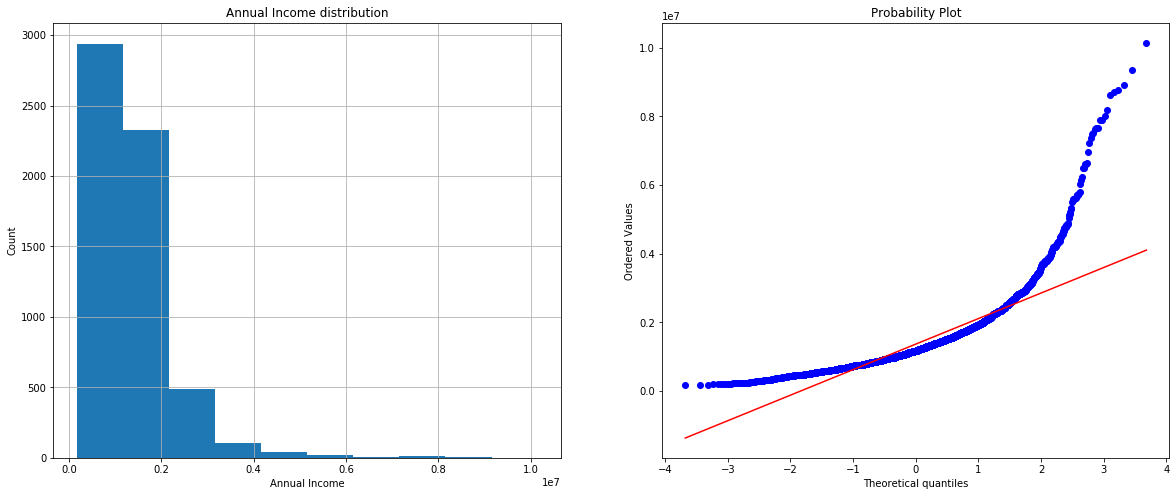

In [13]:
distr_qq_plots(data_without_na, feature, not_null_count(data, feature))

**Выводы**  
годовой доход:
- может оказывать достаточно большое влияние на целевую переменную 
- имеет достаточно большую дисперсию
- не подчиняется нормальному распределению
Следовательно заполнение нулевых значений каким-либо средним значением не будет являться корректным.

**Гипотеза**  
Проверим корреляцию годового дохода с другими признаками и попробуем заполнить пропуски с помощью модели регрессии, обученной на "сильных" признаках.

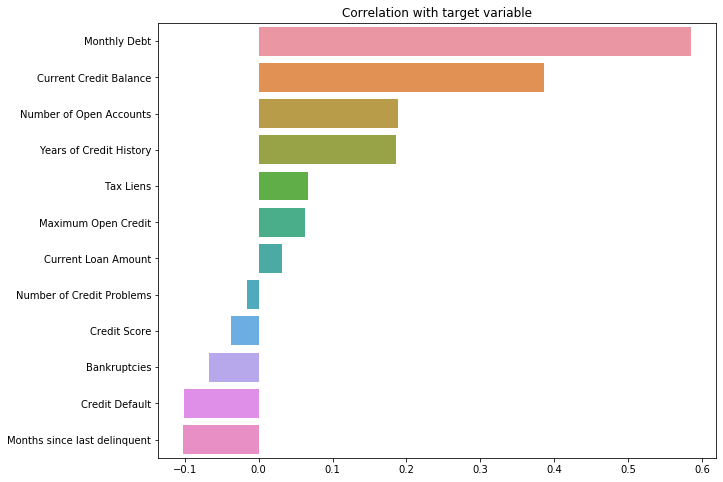

In [14]:
annual_income_corr_features = corr_barplot(data, feature).drop(TARGET_NAME)

После анализа различных моделей (см. model_parameters_selections.ipynb) остановился на градиентном бустинге со следующими параметрами:  
- берем первые 7 коррелирующих признаков
- количество деревьев = 5
- максимальная глубина = 3

In [15]:
x = data_without_na[annual_income_corr_features[:7].index.tolist()]
y = data_without_na[feature]

regressor = xgb.XGBRegressor(n_estimators=5, max_depth=3, random_state = 42)
regressor.fit(x, y);

In [16]:
pred = regressor.predict(data_with_na[annual_income_corr_features[:7].index.tolist()])

data.loc[data_with_na.index.values, feature] = pred

**2. Years in current job**

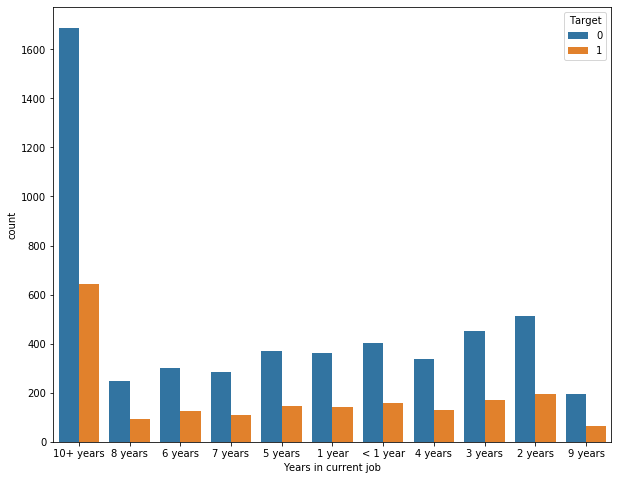

In [17]:
feature = 'Years in current job'

plt.figure(figsize=(10, 8))

sns.countplot(x=feature, hue='Credit Default', data=data)
plt.legend(title='Target', loc='upper right')

plt.show()

**Вывод**  
Как видно из диаграммы, у кредиторов с разным количеством лет на текущей работе схожие доли по отношению к целевой переменной.  
Т. е. можно сделать вывод, что данный признак не оказывает существенного влияния на то, выплатит ли клиент кредит или нет.  
Поэтому принимаем решение исключить данный признак из признакового пространства будущей модели.

**3. Months since last delinquent**

In [18]:
feature = 'Months since last delinquent'

data_with_na = data.loc[data[feature].isnull()]
data_without_na = data.loc[~data[feature].isnull()]

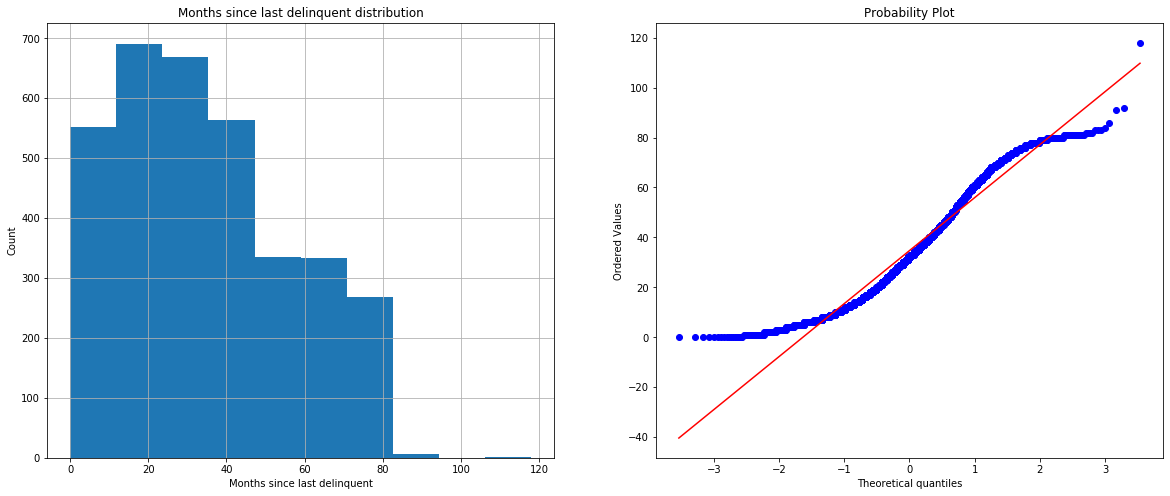

In [19]:
distr_qq_plots(data_without_na, feature, not_null_count(data, feature))

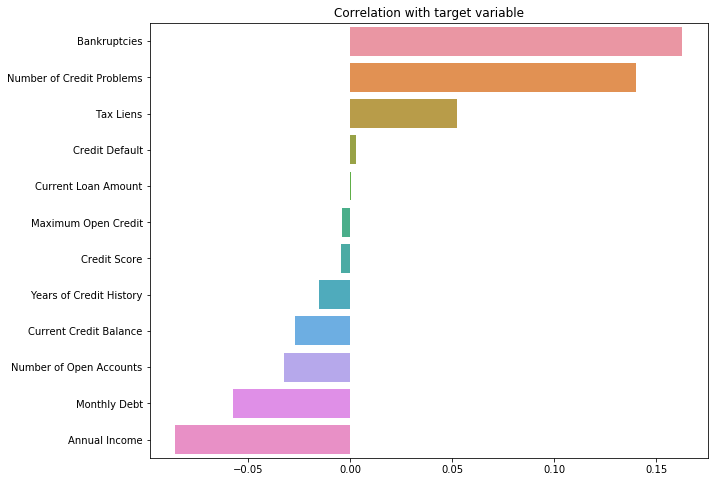

In [20]:
corr_features = corr_barplot(data, feature)

**Пока просто удалю этот параметр. Не совсем понимаю его значение**

**4. Bankruptcies**

In [21]:
feature = 'Bankruptcies'

data_with_na = data.loc[data[feature].isnull()]
data_without_na = data.loc[~data[feature].isnull()]

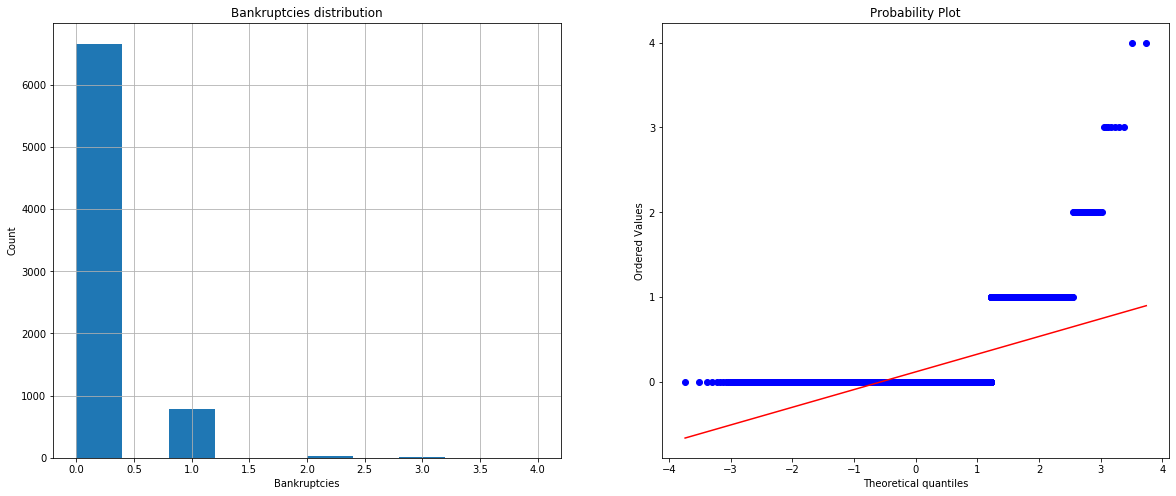

In [22]:
distr_qq_plots(data_without_na, feature, not_null_count(data, feature))

**Вывод**  
Так как большинство клиентов не имело банкротств и количество пропусков не значительно, заполним их "0".

In [23]:
data.loc[data_with_na.index.values, feature] = data_with_na[feature].fillna(0)

**5. Credit Score**

In [24]:
feature = 'Credit Score'

data_with_na = data.loc[data[feature].isnull()]
data_without_na = data.loc[~data[feature].isnull()]

**Отбор признаков**

In [25]:
data = data[(SELECTED_FEATURE_NAMES + [TARGET_NAME])].copy()

**Приведение типов**

In [26]:
for colname in CAT_FEATURE_NAMES:
    data[colname] = pd.Categorical(data[colname])

**Разбиение на train и test**

In [27]:
X = data[SELECTED_FEATURE_NAMES]
y = data[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

# Построение модели

In [28]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

**CatBoost model**

In [29]:
cat_features = [X_train.columns.get_loc(c) for c in CAT_FEATURE_NAMES]

In [30]:
model = catb.CatBoostClassifier(
    n_estimators=500, 
    max_depth=3,
    class_weights=[1, 3.5], 
    silent=True, 
    random_state=21, 
    cat_features=cat_features)

model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.93      0.46      0.61      3771
           1       0.40      0.91      0.55      1479

    accuracy                           0.58      5250
   macro avg       0.66      0.68      0.58      5250
weighted avg       0.78      0.58      0.60      5250

TEST

              precision    recall  f1-score   support

           0       0.87      0.42      0.57      1616
           1       0.36      0.84      0.51       634

    accuracy                           0.54      2250
   macro avg       0.62      0.63      0.54      2250
weighted avg       0.73      0.54      0.55      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               678  938
1               100  534


# Классификация тестовых объектов

In [31]:
base_test_data = pd.read_csv(TEST_DATASET_PATH)
base_test_data.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [32]:
test_data = base_test_data.copy()

In [33]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

**Заключение** Признаки с пропусками в исходных (тренировочных данных) совпадают с теми, что в тестовых данных. Поэтому применим к ним то же форматирование.

In [34]:
# Заполнение пропусков признака Annual Income

feature = 'Annual Income'

data_with_na = test_data.loc[test_data[feature].isnull()]
data_without_na = test_data.loc[~test_data[feature].isnull()]

pred = regressor.predict(data_with_na[annual_income_corr_features[:7].index.tolist()])

test_data.loc[data_with_na.index.values, feature] = pred

In [35]:
# Заполнение пропусков признака Bankruptcies "0"

feature = 'Bankruptcies'

data_with_na = test_data.loc[test_data[feature].isnull()]
data_without_na = test_data.loc[~test_data[feature].isnull()]

test_data.loc[data_with_na.index.values, feature] = data_with_na[feature].fillna(0)

In [36]:
# Отбор признаков

test_data = test_data[(SELECTED_FEATURE_NAMES)].copy()

In [37]:
# Приведение типов для модели CatBoost

for colname in CAT_FEATURE_NAMES:
    test_data[colname] = pd.Categorical(test_data[colname])

In [38]:
# Предсказание

y_test_pred = pd.Series(model.predict(test_data))

y_test_pred.value_counts()

1    1611
0     889
dtype: int64

In [39]:
# Запись предсказаний в файл

y_test_pred.to_csv(PREP_DATASET_PATH, index=False, encoding='utf-8')